In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import joblib

In [52]:
from preprocess import EstateData

dataset = EstateData("final.csv")

In [53]:
dataset.split_data(stratify=True)

In [54]:
dataset.preprocess(tukey=True)

Start Process!
Fill missing values: Done
Remove outlier: Done
Scale features: Done


In [55]:
train = dataset.train
test = dataset.test

In [56]:
print("train size {}".format(train.shape))
print("test size {}".format(test.shape))

train size (31658, 12)
test size (9278, 12)


In [57]:
train.head()

,House Direction,Balcony Direction,Toilets,Bedrooms,Legits,Floors,Facade,Entrance,Area,X,Y,PricePerM2
44585,None,None,None,6,None,7,-0.229205,0.000000,-0.282051,0.274513,-0.913402,1238.636364
13963,None,None,3,5,+đỏ+hồng,3,0.390269,7.600665,1.153846,1.065550,0.917988,120.000000
10935,tây nam,tây nam,10+,10+,+đỏ,6,0.646900,-7.399335,0.000000,0.349404,0.077626,145.454545
3503,None,None,4,4,None,5,-0.253984,-5.899335,-0.692308,0.148615,0.071339,160.714286
23474,tây nam,None,5,3,None,5,-0.105311,0.000000,-0.512821,0.299602,0.649355,168.571429


In [58]:
test.isnull().mean()

House Direction      0.0
Balcony Direction    0.0
Toilets              0.0
Bedrooms             0.0
Legits               0.0
Floors               0.0
Facade               0.0
Entrance             0.0
Area                 0.0
X                    0.0
Y                    0.0
PricePerM2           0.0
dtype: float64

In [59]:
train, dev = train_test_split(train, test_size=0.2, random_state=0)

In [60]:
features = train.columns.tolist()
features.remove("PricePerM2")


In [61]:
xgb = XGBRegressor(n_estimators = 300, max_depth=20, eta=0.01, gamma=1, tree_method="gpu_hist", subsample=1, objective="reg:squarederror", enable_categorical=True)

In [62]:
xgb.fit(train[features], train["PricePerM2"], eval_set=[(dev[features], dev["PricePerM2"])], eval_metric="mape", early_stopping_rounds=20)

C:\Users\vietdata\anaconda3\envs\ML_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\vietdata\anaconda3\envs\ML_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mape:0.98283
[1]	validation_0-mape:0.97101
[2]	validation_0-mape:0.95962
[3]	validation_0-mape:0.94840
[4]	validation_0-mape:0.93739
[5]	validation_0-mape:0.92667
[6]	validation_0-mape:0.91607
[7]	validation_0-mape:0.90581
[8]	validation_0-mape:0.89551
[9]	validation_0-mape:0.88559
[10]	validation_0-mape:0.87600
[11]	validation_0-mape:0.86665
[12]	validation_0-mape:0.85776
[13]	validation_0-mape:0.84919
[14]	validation_0-mape:0.84081
[15]	validation_0-mape:0.83257
[16]	validation_0-mape:0.82453
[17]	validation_0-mape:0.81662
[18]	validation_0-mape:0.80883
[19]	validation_0-mape:0.80119
[20]	validation_0-mape:0.79392
[21]	validation_0-mape:0.78677
[22]	validation_0-mape:0.77967
[23]	validation_0-mape:0.77271
[24]	validation_0-mape:0.76584
[25]	validation_0-mape:0.75909
[26]	validation_0-mape:0.75240
[27]	validation_0-mape:0.74589
[28]	validation_0-mape:0.73944
[29]	validation_0-mape:0.73308
[30]	validation_0-mape:0.72684
[31]	validation_0-mape:0.72065
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eta=0.01, eval_metric=None,
             feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [63]:
with open("log/best_tree.txt", "w") as f:
    f.write(str(xgb.best_ntree_limit))

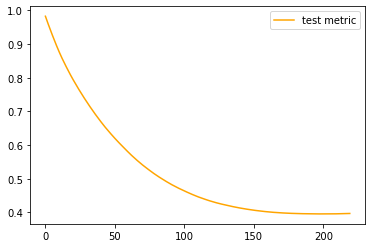

In [64]:
results = xgb.evals_result()
#plt.plot(results["validation_0"]["mape"], c= "b", label="train metric")
plt.plot(results["validation_0"]["mape"], c= "orange", label="test metric")
plt.legend()

In [50]:
pred = xgb.predict(test[features],ntree_limit=xgb.best_ntree_limit)
print(mape(test["PricePerM2"], pred))

C:\Users\vietdata\anaconda3\envs\ML_env\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.4876007931318934


In [17]:
joblib.dump(xgb, "log/best_tree.pkl") 

['log/best_tree.pkl']

In [18]:
joblib.load("log/best_tree.pkl").best_ntree_limit

147

In [22]:
xgb.save_model("log/xgb.json")

In [18]:
import pandas as pd